# Benchmark Trained Gemma Model on AI2 ARC Dataset

This notebook benchmarks your trained Gemma model on the AI2 Reasoning Challenge (ARC) dataset, a collection of grade-school level, multiple-choice science questions designed to evaluate reasoning abilities in AI models.

## 1. Install Dependencies

First, let's make sure we have all required packages.

In [ ]:
!pip install torch transformers datasets tqdm

## 2. Import Libraries

In [1]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
import matplotlib.pyplot as plt

## 3. Configure Benchmark Parameters

Set the parameters for your benchmark run.

In [2]:
# Benchmark parameters
class Args:
    def __init__(self):
        self.model_path = 'gemma_glicko'  # Path to your trained Gemma model
        self.dataset_config = 'ARC-Challenge'  # 'ARC-Easy' or 'ARC-Challenge'
        self.split = 'test'  # 'train', 'validation', or 'test'
        self.batch_size = 8  # Batch size for evaluation
        self.max_samples = 50  # Set to None for all samples, or use a smaller number for testing
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.max_length = 512  # Maximum sequence length for generation
        self.output_file = 'gemma_arc_benchmark_results.json'  # Results file path

args = Args()

# Display configuration
print(f"Model path: {args.model_path}")
print(f"Dataset: AI2 ARC {args.dataset_config}, {args.split} split")
print(f"Max samples: {args.max_samples if args.max_samples else 'All'}")
print(f"Device: {args.device}")

Model path: gemma_glicko
Dataset: AI2 ARC ARC-Challenge, test split
Max samples: 50
Device: cuda


## 4. Define Helper Functions

In [35]:
def format_prompt(question, choices):
    """Format the prompt for the model."""
    formatted_choices = ""
    for i, (label, text) in enumerate(zip(choices['label'], choices['text'])):
        formatted_choices += f"{label}) {text}\n"
    
    prompt = f"Question: {question}\n\nChoices:\n{formatted_choices}\nAnswer:"
    return prompt

def extract_answer(output_text):
    """Extract the answer from the model's output text."""
    # First, look for just the letter answer (A, B, C, D or E)
    for token in output_text.split():
        clean_token = token.strip().rstrip('.,:;!?').upper()
        if clean_token in ['A', 'B', 'C', 'D', 'E']:
            return clean_token
    
    # If not found, look for patterns like "the answer is B" or "option C"
    common_phrases = ["answer is", "option", "choice"]
    output_text = output_text.upper()
    
    for phrase in common_phrases:
        phrase = phrase.upper()
        if phrase in output_text:
            phrase_idx = output_text.find(phrase) + len(phrase)
            remaining_text = output_text[phrase_idx:].strip()
            
            for answer in ['A', 'B', 'C', 'D', 'E']:
                if remaining_text.startswith(answer) or f" {answer}" in remaining_text[:10]:
                    return answer
    
    # If still not found, just return the first letter that matches an answer choice
    for char in output_text:
        if char in ['A', 'B', 'C', 'D', 'E']:
            return char
    
    # If everything fails, return None
    return None

## 5. Load Model and Dataset

In [24]:
# Load model and tokenizer
print(f"Loading model from {args.model_path}...")
tokenizer = AutoTokenizer.from_pretrained(args.model_path)
model = AutoModelForCausalLM.from_pretrained(
    args.model_path,
    torch_dtype=torch.float16 if args.device == 'cuda' else torch.float32,
    device_map="auto" if args.device == 'cuda' else None
)

# Add padding token if not set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load dataset
print(f"Loading AI2 ARC dataset ({args.dataset_config})...")
dataset = load_dataset("allenai/ai2_arc", args.dataset_config, split=args.split)
print(f"Dataset loaded, {len(dataset)} examples found.")

# Display a sample question
example = dataset[0]
print("\nSample question:")
print(f"Question: {example['question']}")
print("Choices:")
for label, text in zip(example['choices']['label'], example['choices']['text']):
    print(f"{label}) {text}")
print(f"Correct answer: {example['answerKey']}")

Loading model from gemma_glicko...
Loading AI2 ARC dataset (ARC-Challenge)...
Dataset loaded, 1172 examples found.

Sample question:
Question: An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?
Choices:
A) Planetary density will decrease.
B) Planetary years will become longer.
C) Planetary days will become shorter.
D) Planetary gravity will become stronger.
Correct answer: C


## 6. Evaluate Model on Dataset

In [25]:
def evaluate_model(model, tokenizer, dataset, args):
    """Evaluate the model on the dataset."""
    model.eval()
    correct = 0
    total = 0
    results = []
    
    # Determine number of samples to evaluate
    num_samples = len(dataset) if args.max_samples is None else min(args.max_samples, len(dataset))
    dataset = dataset.select(range(num_samples))
    
    for i, example in enumerate(tqdm(dataset, desc="Evaluating")):
        prompt = format_prompt(example['question'], example['choices'])
        inputs = tokenizer(prompt, return_tensors="pt").to(args.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=args.max_length,
                num_return_sequences=1,
                temperature=0.1,  # Lower temperature for more focused answers
                do_sample=False,  # Use greedy decoding for deterministic answers
            )
        
        output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        output_text = output_text[len(prompt):]  # Remove the prompt from the output
        
        predicted_answer = extract_answer(output_text)
        correct_answer = example['answerKey']
        # Check if prediction is correct
        is_correct = predicted_answer == correct_answer
        if is_correct:
            correct += 1
        total += 1
        
        # Save result
        result = {
            'id': example['id'],
            'question': example['question'],
            'choices': example['choices'],
            'correct_answer': correct_answer,
            'predicted_answer': predicted_answer,
            'model_output': output_text,
            'is_correct': is_correct
        }
        results.append(result)
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Progress: {i+1}/{num_samples}, Accuracy: {correct/total:.4f}")
    
    final_accuracy = correct / total if total > 0 else 0
    print(f"\nFinal Accuracy: {final_accuracy:.4f} ({correct}/{total})")
    
    # Save results
    results_data = {
        'model_path': args.model_path,
        'dataset_config': args.dataset_config,
        'split': args.split,
        'accuracy': final_accuracy,
        'correct': correct,
        'total': total,
        'results': results
    }
    
    with open(args.output_file, 'w') as f:
        json.dump(results_data, f, indent=2)
    
    print(f"Results saved to {args.output_file}")
    return final_accuracy, results_data

In [26]:
# Run the evaluation
accuracy, results_data = evaluate_model(model, tokenizer, dataset, args)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Progress: 10/50, Accuracy: 0.5000
Progress: 20/50, Accuracy: 0.5000
guess
Progress: 30/50, Accuracy: 0.4667
Progress: 40/50, Accuracy: 0.5000
Progress: 50/50, Accuracy: 0.4600

Final Accuracy: 0.4600 (23/50)
Results saved to gemma_arc_benchmark_results.json


## 7. Basic Results Analysis

In [27]:
# Create results dataframe for analysis
import pandas as pd

def create_dataframe(results):
    """Convert results to pandas DataFrame for analysis."""
    records = []
    for item in results['results']:
        record = {
            'id': item['id'],
            'question': item['question'],
            'correct_answer': item['correct_answer'],
            'predicted_answer': item['predicted_answer'],
            'is_correct': item['is_correct'],
            'output_length': len(item['model_output']),
            'num_choices': len(item['choices']['label']),
        }
        # Add question length
        record['question_length'] = len(item['question'].split())
        
        # Add question features
        lowercase_question = item['question'].lower()
        record['has_why'] = 'why' in lowercase_question
        record['has_what'] = 'what' in lowercase_question
        record['has_how'] = 'how' in lowercase_question
        record['has_which'] = 'which' in lowercase_question
        record['has_when'] = 'when' in lowercase_question
        record['has_where'] = 'where' in lowercase_question
        
        records.append(record)
    
    return pd.DataFrame(records)

# Create DataFrame
df = create_dataframe(results_data)
print(f"DataFrame created with {len(df)} rows")
df.head()

DataFrame created with 50 rows


,id,question,correct_answer,predicted_answer,is_correct,output_length,num_choices,question_length,has_why,has_what,has_how,has_which,has_when,has_where
0,Mercury_7175875,An astronomer observes that a planet rotates f...,C,B,False,1793,4,23,False,False,False,True,False,False
1,Mercury_SC_409171,A group of engineers wanted to know how differ...,B,B,True,711,4,42,False,False,True,True,False,False
2,Mercury_SC_408547,The end result in the process of photosynthesi...,C,B,False,269,4,22,False,False,False,True,False,False
3,Mercury_407327,A physicist wants to determine the speed a car...,D,C,False,1662,4,48,False,True,False,False,True,False
4,MCAS_2006_9_44,An astronaut drops a 1.0 kg object and a 5.0 k...,D,B,False,1804,4,42,False,False,False,True,False,False


In [28]:
# Basic statistics
print("\n=== Basic Statistics ===")
print(f"Overall Accuracy: {df['is_correct'].mean():.4f}")

# Predicted answer distribution
print("\nPredicted Answer Distribution:")
pred_counts = df['predicted_answer'].value_counts()
print(pred_counts)

# Correct answer distribution
print("\nCorrect Answer Distribution:")
correct_counts = df['correct_answer'].value_counts()
print(correct_counts)

# Accuracy by question type
print("\nAccuracy by Question Type:")
question_types = ['has_why', 'has_what', 'has_how', 'has_which', 'has_when', 'has_where']
for q_type in question_types:
    type_df = df[df[q_type] == True]
    if len(type_df) > 0:
        print(f"{q_type.replace('has_', '').capitalize()}: {type_df['is_correct'].mean():.4f} ({len(type_df)} questions)")


=== Basic Statistics ===
Overall Accuracy: 0.4600

Predicted Answer Distribution:
predicted_answer
A    19
B    13
C    12
D     6
Name: count, dtype: int64

Correct Answer Distribution:
correct_answer
C    19
B    15
A    10
D     5
2     1
Name: count, dtype: int64

Accuracy by Question Type:
Why: 1.0000 (1 questions)
What: 0.5714 (7 questions)
How: 0.6250 (8 questions)
Which: 0.4545 (33 questions)
When: 0.6667 (3 questions)


## 8. Visualize Results

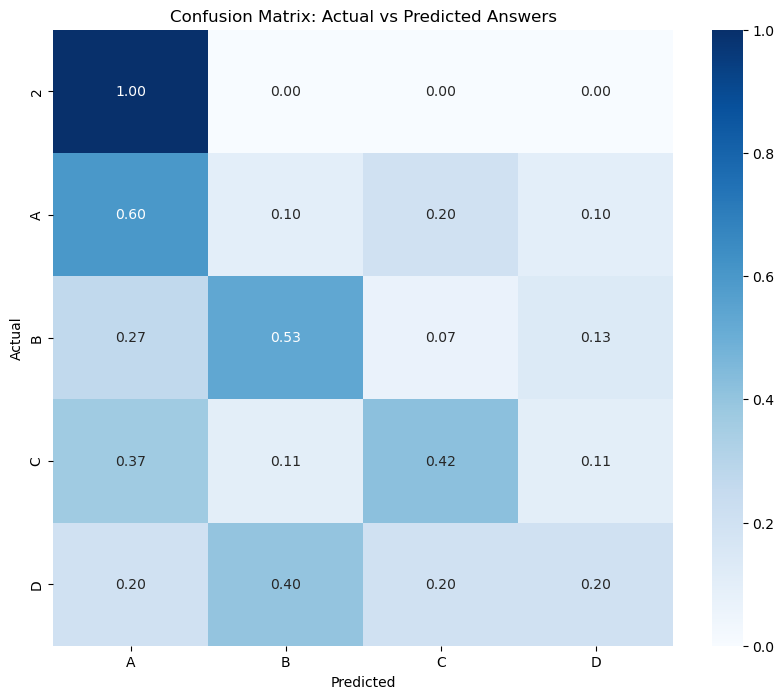

In [29]:
# 1. Confusion Matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
confusion = pd.crosstab(df['correct_answer'], df['predicted_answer'], 
                       rownames=['Actual'], colnames=['Predicted'],
                       normalize='index')
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix: Actual vs Predicted Answers')
plt.show()

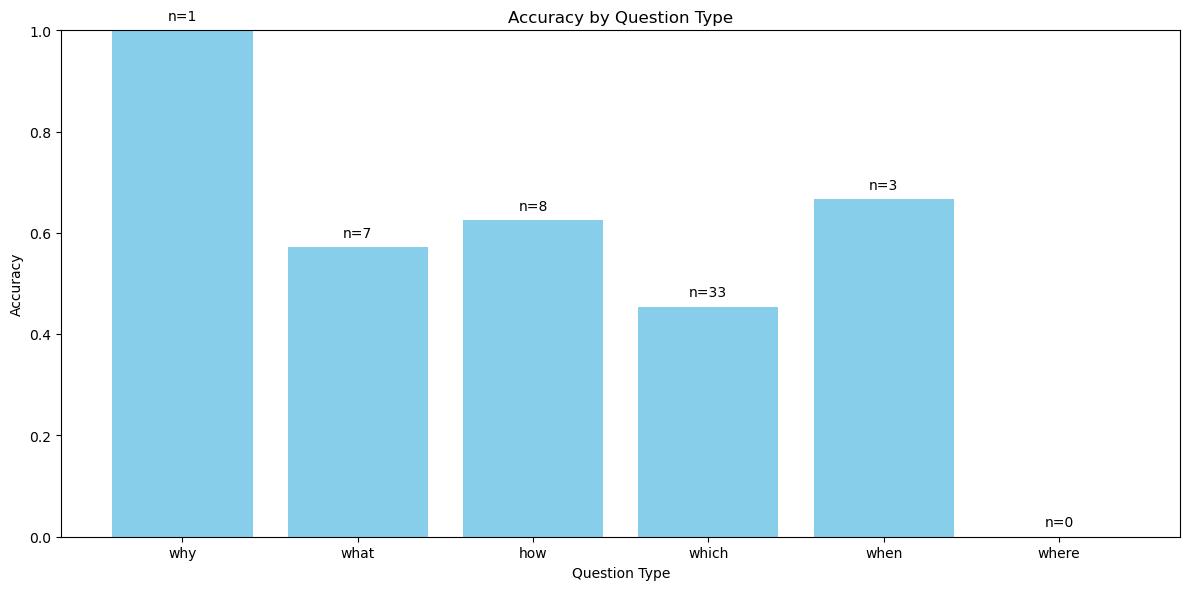

In [30]:
# 2. Accuracy by Question Type
question_types = ['has_why', 'has_what', 'has_how', 'has_which', 'has_when', 'has_where']
accuracies = []
counts = []

for q_type in question_types:
    type_df = df[df[q_type] == True]
    type_acc = type_df['is_correct'].mean() if len(type_df) > 0 else 0
    type_count = len(type_df)
    
    accuracies.append(type_acc)
    counts.append(type_count)

plt.figure(figsize=(12, 6))
plt.bar([q.replace('has_', '') for q in question_types], accuracies, color='skyblue')
plt.title('Accuracy by Question Type')
plt.xlabel('Question Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add count labels above bars
for i, (acc, count) in enumerate(zip(accuracies, counts)):
    plt.text(i, acc + 0.02, f"n={count}", ha='center')

plt.tight_layout()
plt.show()

Accuracy by question length:
                  mean  count
q_length_bin                 
0-10          0.500000      8
11-20         0.500000     12
21-30         0.333333     15
31-40         0.400000      5
41-50         0.571429      7
51-100        0.666667      3
100+               NaN      0


/tmp/ipykernel_8083/3832210457.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_accuracy = df.groupby('q_length_bin')['is_correct'].agg(['mean', 'count'])
/tmp/ipykernel_8083/3832210457.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, length_accuracy['mean'][i] + 0.02, f"n={count}", ha='center')


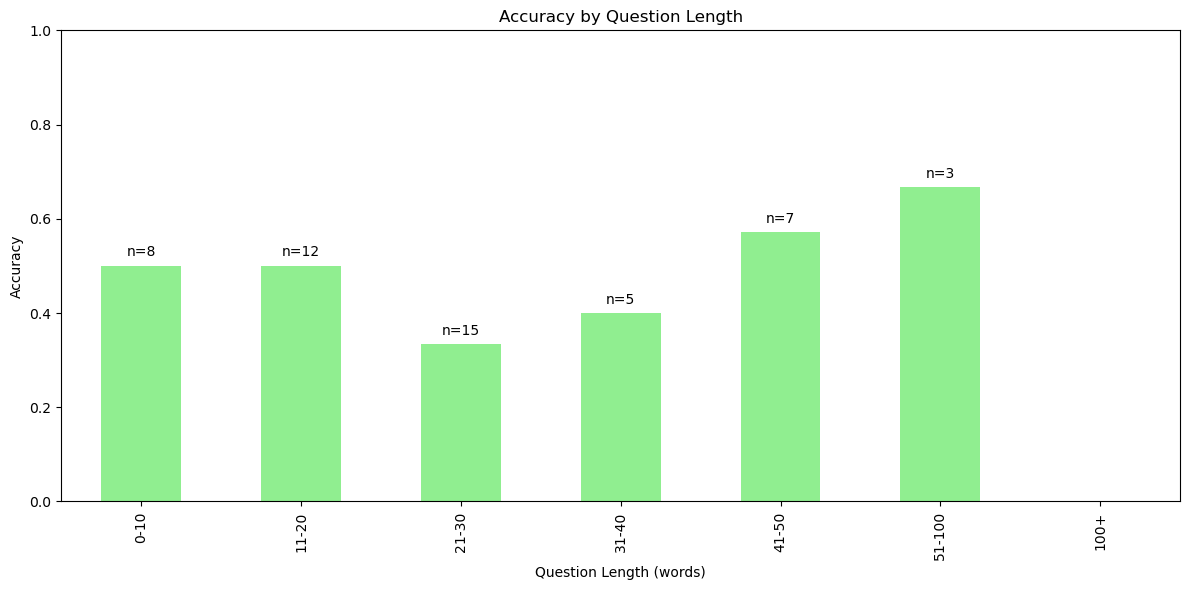

In [31]:
# 3. Accuracy by Question Length
# Create bins for question length
bins = [0, 10, 20, 30, 40, 50, 100, 1000]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-100', '100+']
df['q_length_bin'] = pd.cut(df['question_length'], bins=bins, labels=labels)

# Accuracy by question length
length_accuracy = df.groupby('q_length_bin')['is_correct'].agg(['mean', 'count'])
print("Accuracy by question length:")
print(length_accuracy)

# Plot
plt.figure(figsize=(12, 6))
ax = length_accuracy['mean'].plot(kind='bar', color='lightgreen')
plt.title('Accuracy by Question Length')
plt.xlabel('Question Length (words)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add count labels
for i, count in enumerate(length_accuracy['count']):
    plt.text(i, length_accuracy['mean'][i] + 0.02, f"n={count}", ha='center')

plt.tight_layout()
plt.show()

## 9. Examine Example Predictions

In [36]:
# Show some correct predictions
correct_examples = df[df['is_correct'] == True].sample(3)
print("=== CORRECT PREDICTIONS ===")
for i, row in correct_examples.iterrows():
    result = next(r for r in results_data['results'] if r['id'] == row['id'])
    print(f"\nQuestion: {row['question']}")
    print("Choices:")
    for label, text in zip(result['choices']['label'], result['choices']['text']):
        print(f"{label}) {text}")
    print(f"Correct answer: {row['correct_answer']}")
    print(f"Predicted answer: {row['predicted_answer']}")
    print(f"Model output: {result['model_output']}")
    print("-" * 80)

# Show some incorrect predictions
incorrect_examples = df[df['is_correct'] == False].sample(3)
print("\n=== INCORRECT PREDICTIONS ===")
for i, row in incorrect_examples.iterrows():
    result = next(r for r in results_data['results'] if r['id'] == row['id'])
    print(f"\nQuestion: {row['question']}")
    print("Choices:")
    for label, text in zip(result['choices']['label'], result['choices']['text']):
        print(f"{label}) {text}")
    print(f"Correct answer: {row['correct_answer']}")
    print(f"Predicted answer: {row['predicted_answer']}")
    print(f"Model output: {result['model_output']}")
    print("-" * 80)

=== CORRECT PREDICTIONS ===

Question: Which statement best explains why a tree branch floats on water?
Choices:
A) Wood is porous.
B) Wood is buoyant.
C) Wood is light.
D) Wood is magnetic.
Correct answer: B
Predicted answer: B
Model output:  B
Explanation:
The correct answer is B.
Here's why:
*   **B) Wood is buoyant.** This is the most accurate explanation.  The porous structure of wood allows it to be less dense than water, creating buoyancy.
*   **A) Wood is porous.** While porous wood *can* contribute to buoyancy, it's not the primary reason.
*   **C) Wood is light.** While wood is generally lightweight, it's not the main factor in floating.
*   **D) Wood is magnetic.** This is a false statement. Wood is not magnetic.

Final Answer: The final answer is $\boxed{B}$
--------------------------------------------------------------------------------

Question: At which temperature does water freeze?
Choices:
A) 0 degrees Celsius
B) 32 degrees Celsius
C) 100 degrees Celsius
D) 212 degre

## 10. Compare with Reference Models

For reference, here are benchmark scores on ARC-Challenge for various models:

| Model               | ARC-Challenge Accuracy |
|---------------------|------------------------|
| Random Baseline     | 0.25                   |
| Gemma 2B            | ~0.43                  |
| Gemma 7B            | ~0.53                  |
| Gemma 2 9B          | ~0.58                  |
| Gemma 2 27B         | ~0.64                  |
| Gemma 3 27B         | ~0.67                  |
| Specialized Models  | >0.90                  |

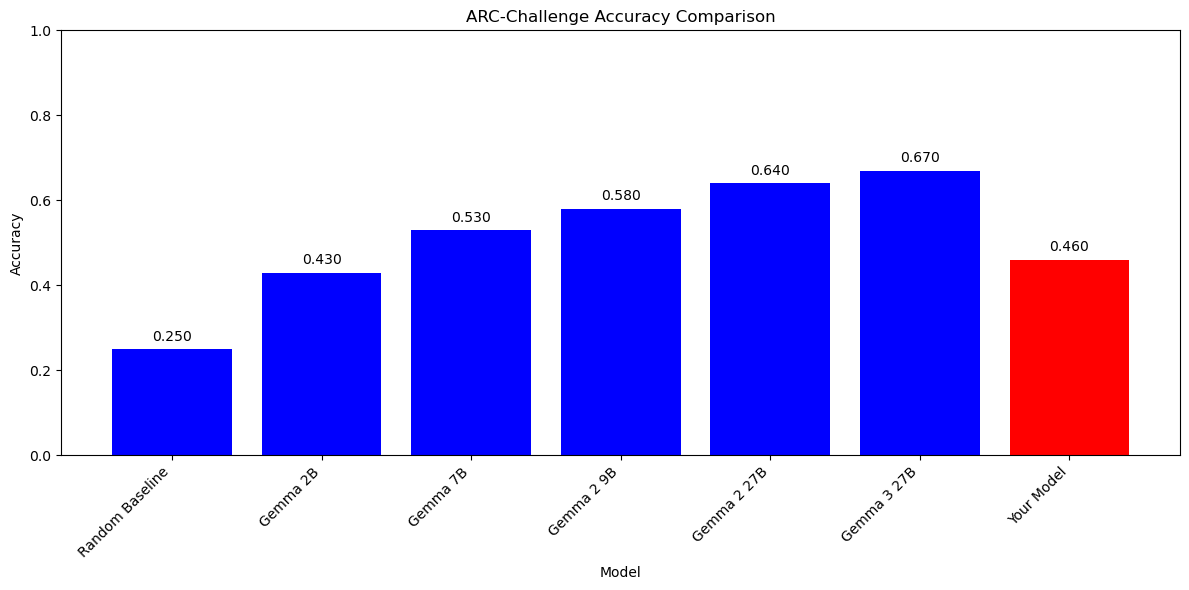

In [33]:
# Plot comparison with reference models
reference_models = {
    'Random Baseline': 0.25,
    'Gemma 2B': 0.43,
    'Gemma 7B': 0.53,
    'Gemma 2 9B': 0.58,
    'Gemma 2 27B': 0.64,
    'Gemma 3 27B': 0.67,
    'Your Model': accuracy  # Your model's accuracy
}

plt.figure(figsize=(12, 6))
models = list(reference_models.keys())
accs = list(reference_models.values())

# Highlight your model
colors = ['blue'] * len(models)
colors[models.index('Your Model')] = 'red'

plt.bar(models, accs, color=colors)
plt.title('ARC-Challenge Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values above bars
for i, acc in enumerate(accs):
    plt.text(i, acc + 0.02, f"{acc:.3f}", ha='center')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 11. Conclusion and Next Steps

Based on the benchmark results, here are some potential next steps to improve model performance:

1. **Few-shot prompting**: Include a few examples in the prompt to provide more context.
2. **Chain-of-thought**: Encourage step-by-step reasoning by changing the prompt format.
3. **Fine-tuning on science data**: Consider additional training on science-related datasets.
4. **Prompt engineering**: Experiment with different prompt formats to improve response quality.
5. **Ensemble methods**: Combine multiple versions of your model or try different prompting strategies.